An indepth example to understand the difference between a `torch.tensor` (require_grad = false/true), `nn.Parameter`, and buffers `register_buffer`.

In [25]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Tensors vs Parameters vs Buffers: What is the difference?

Parameters are Tensor subclasses, that have a very special property when used with Module s - when they’re assigned as Module attributes they are automatically added to the list of its parameters, and will appear e.g. in parameters() iterator. Buffers are Tensor subclasses, that have a very special property when used with Module s – when they’re assigned as Module attributes they are automatically added to the list of its buffers, and will appear e.g. in buffers() iterator. Assigning a Tensor doesn’t have such effect. One can still assign a Tensor as explicitly by using the register_buffer() function. Buffers act like persistent, non-trainable data that you want to associate with your module. They are saved and loaded as part of the model's state_dict, alongside trainable parameters.

<b>Example 1</b>

In [3]:
class CustomModule(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 1. Plain Tensor (NOT registered at all)
        self.plain_tensor = torch.tensor([1.0, 2.0, 3.0])  # requires_grad=False
        
        # 2. Plain Tensor with requires_grad=True (Still NOT registered!)
        self.unregistered_tensor = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)

        # 3. nn.Parameter (WILL be registered as a learnable parameter)
        self.learnable_param = nn.Parameter(torch.tensor([1.0, 2.0, 3.0]))

        # 4. Buffer (NOT a parameter, but registered as persistent state)
        self.register_buffer('running_average', torch.tensor([0.0, 0.0, 0.0]))

    def forward(self, x):
        # Use all values in some way
        self.running_average = 0.9 * self.running_average + 0.1 * x.mean(dim=0)
        return x * self.learnable_param.sum()  # Just some computation

In [4]:
model = CustomModule()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [5]:
# Dummy input
x = torch.tensor([[1.0, 2.0, 3.0]], requires_grad=True)

# Forward
output = model(x)
loss = output.sum()
loss.backward()

# Check gradients
print("Gradient of learnable_param:", model.learnable_param.grad)
print("Gradient of unregistered_tensor:", model.unregistered_tensor.grad)  # This stays None
print("Buffer running_average:", model.running_average)

# Step optimizer
optimizer.step()

Gradient of learnable_param: tensor([6., 6., 6.])
Gradient of unregistered_tensor: None
Buffer running_average: tensor([0.1000, 0.2000, 0.3000], grad_fn=<AddBackward0>)


As observed: 
* learnable_param.grad → Will have gradient, and its value will be updated by optimizer.
* unregistered_tensor.grad → Is None. Even though requires_grad=True, it's not part of model.parameters(), so optimizer ignores it.
* running_average → Gets updated inside forward() but has no gradients (and not learned). Still saved in state_dict().
* plain_tensor → Is just a float tensor sitting in the class — not tracked, no gradients, not saved.

We can see in depth inside the model state_dict, that both the parameters `learnable_param` as well as the registered buffer `running_average` are saved in `state_dict()`.

In [7]:
model.state_dict()

OrderedDict([('learnable_param', tensor([0.4000, 1.4000, 2.4000])),
             ('running_average', tensor([0.1000, 0.2000, 0.3000]))])

We can list down the registered buffers using `named_buffers()` and the parameters using `named_parameters()`.

In [11]:
print(list(model.named_buffers()))
print(list(model.named_parameters()))

[('running_average', tensor([0.1000, 0.2000, 0.3000], grad_fn=<AddBackward0>))]
[('learnable_param', Parameter containing:
tensor([0.4000, 1.4000, 2.4000], requires_grad=True))]


<b> Example 2 </b>

In [12]:
# Here, the state consists of randomly-initialized weight and bias tensors that define the affine transformation. 
# Because each of these is defined as a Parameter, they are registered for the module and will automatically be tracked and 
# returned from calls to parameters()

class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_features, out_features))
        self.bias = nn.Parameter(torch.randn(out_features))
        
    def forward(self, input):
        return (input @ self.weight) + self.bias

linear_layer = LinearLayer(3, 4)

# it is a generator object
# print(linear_layer.parameters())

# note that the parameters are given the names of the class declared parameter variables
for name, param in linear_layer.named_parameters():
    print(f"Parameter: {name}, Values: {param}, Requires Grad: {param.requires_grad}")

x_input = torch.randn(3)
y_output = linear_layer(x_input)
print(f"\ninput: {x_input}.\noutput: {y_output}")

Parameter: weight, Values: Parameter containing:
tensor([[ 1.0101,  0.5176, -0.7210,  0.1325],
        [ 0.8209,  0.1945,  1.9543, -0.1676],
        [ 0.4792,  0.5259,  1.0869,  1.6193]], requires_grad=True), Requires Grad: True
Parameter: bias, Values: Parameter containing:
tensor([-0.2168,  0.8733,  0.0970, -0.8487], requires_grad=True), Requires Grad: True

input: tensor([-0.1310, -0.0959, -0.5971]).
output: tensor([-0.7139,  0.4728, -0.6449, -1.8169], grad_fn=<AddBackward0>)


In [13]:
# The parameter below
param1 = nn.Parameter(torch.randn(3, 3)) # torch.Size([3, 3]), requires_grad=True as default
print(param1.requires_grad)

# is similar to ...
tensor = torch.randn(3, 3, requires_grad= True) # Not a parameter!
param2 = nn.Parameter(tensor)
print(param2.requires_grad)

# but tensor is not a parameter by it's own, meaning that it won't be found in the list of model.parameters()
# thus, tensor is not registered as a trainable parameter

# When a tensor is wrapped with nn.Parameter and assigned as an attribute of an nn.Module, 
# it's automatically added to the list returned by model.parameters() and model.named_parameters(), similar to the
# example in the previous cell. The optimizer (e.g., torch.optim.Adam) will also update nn.Parameters during training.
# Therefor, nn.Parameter allows you to introduce weights that are learnable.

# Note, to freeze a parameter, we can use param.requires_grad = False
# It will stay in model.parameters() but will not receive gradient updates.

True
True


<b>Example 3</b>

In [15]:
class ModelWithBuffers(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Learnable parameter
        self.scale = nn.Parameter(torch.tensor(1.0))
        
        # Buffers (not learnable but persistent)
        self.register_buffer('ema_loss', torch.tensor(0.0))
        self.register_buffer('global_step', torch.tensor(0))

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return self.scale * x

    def update_ema(self, loss, momentum=0.95):
        self.ema_loss = momentum * self.ema_loss + (1 - momentum) * loss.detach()
        self.global_step += 1

In [16]:
# Generate Dummy Data
torch.manual_seed(0)
X = torch.randn(100, 5)
true_weights = torch.tensor([1.5, -2.0, 0.5, 3.0, -1.0])
y = X @ true_weights + 0.1 * torch.randn(100)

In [20]:
X.shape, y.shape

(torch.Size([100, 5]), torch.Size([100]))

In [21]:
# Creating an instance for the model, optim, and loss
model = ModelWithBuffers(input_dim=5, hidden_dim=10, output_dim=1)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [23]:
model

ModelWithBuffers(
  (fc1): Linear(in_features=5, out_features=10, bias=True)
  (activation): ReLU()
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)

In [24]:
losses = []
ema_losses = []

for epoch in range(50):
    optimizer.zero_grad()
    outputs = model(X).squeeze()
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    
    model.update_ema(loss)

    losses.append(loss.item())
    ema_losses.append(model.ema_loss.item())

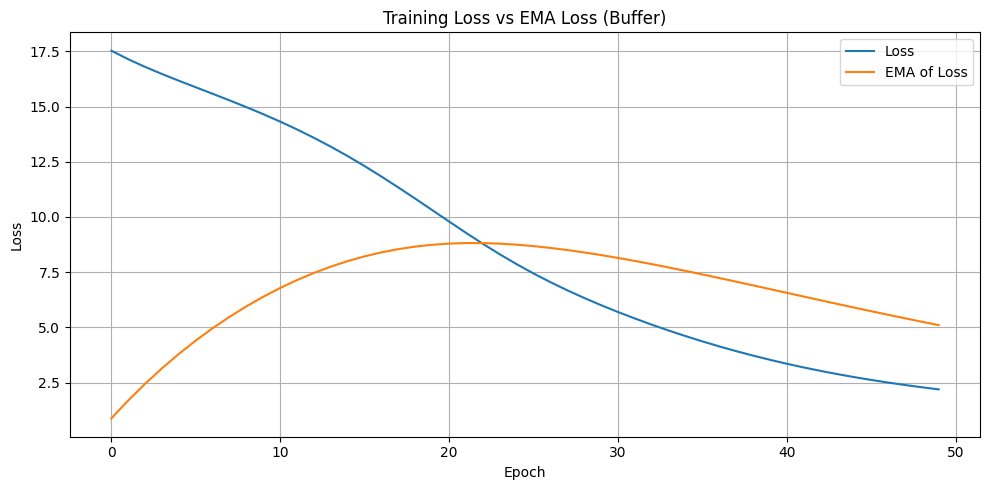

In [26]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label="Loss")
plt.plot(ema_losses, label="EMA of Loss")
plt.title("Training Loss vs EMA Loss (Buffer)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Inspecting the buffers - it is useful to keep the `global_step` in the model `state_dict()` as a buffer to continue training when saving and loading the model `state_dict()`. `ema_loss` stores a moving average, useful for EMA-based stopping criteria or even learning rate scheduling. Buffers also move with the model on the same device.

In [27]:
# inspecting the buffers
for name, buf in model.named_buffers():
    print(f"{name}: {buf}")

ema_loss: 5.099499702453613
global_step: 50


Saving and loading the model with parameters and buffers.

In [28]:
# torch.save(model.state_dict(), "model_with_buffers.pt")
# new_model = MyModelWithBuffers(5, 10, 1)
# new_model.load_state_dict(torch.load("model_with_buffers.pt"))